# Speach Recognition Tutorial
Hey Every one,
In this notebook we are going to impletement a simple speech recogntion tutorial the name is complex but the work flow is very simple. If you going to speech recognition and you don't work with speechs this tutorial is necessary for you. becuase it like mnist dataset in images.
If you have speechs in .wav extentions first you convert this speech files to images so that you can easily work with cnn. In this notebook the main idea is to convert raw speechs to spectrogram(images) with shape (height,width,channels)

# Tip
If you are going to build Speach Emotion Recongtion , The next stage is this:

Stage 2 — CRNN (CNN + RNN) — capture time & freq

Goal: Keep CNN for local time-freq patterns, add RNN (LSTM/GRU) on top to model temporal dynamics.

Why: Speech is sequential — CRNN commonly improves over pure CNN. Many papers / notebooks show this approach.
PMC
+1

What to implement

From mel-spectrogram (shape: frames × mel_bins), treat frames as sequence.

Apply 2D conv layers (or 1D conv along time), then reshape to (time, features).

Feed into Bidirectional LSTM / GRU (return_sequences=True).

Final Dense softmax per utterance (or frame-level pooling then softmax).

In [14]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import seaborn as sns

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [15]:
DATASET_PATH = 'data/mini_speech_commands'

data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')

182082353/182082353 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step


In [18]:
import os
BASE_DIR = "/content/data"
os.listdir(BASE_DIR)

['mini_speech_commands_extracted', 'mini_speech_commands.zip']

In [19]:
os.path.join(BASE_DIR,'mini_speach_commands_extracted')

'/content/data/mini_speach_commands_extracted'

In [34]:
WORKING_DIR = '/content/data/mini_speech_commands_extracted/mini_speech_commands'

In [39]:
commands = tf.io.gfile.listdir(WORKING_DIR)
commands

['up', 'left', 'down', 'right', 'no', 'go', 'README.md', 'stop', 'yes']

In [40]:
commands.remove('README.md')

In [41]:
commands

['up', 'left', 'down', 'right', 'no', 'go', 'stop', 'yes']

In [43]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=WORKING_DIR,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset='both')

Found 8000 files belonging to 8 classes.
Using 6400 files for training.
Using 1600 files for validation.


We must convert our dataset into train_ds,test and validation _ds. and max_length of any speech is 16000 so we all convert into 16000 if less then 1 second then we pad to zero .

In [46]:
label_names = np.array(train_ds.class_names)
print(label_names)

['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


In [47]:
len(train_ds
    )

100

In [50]:
train_ds.element_spec

(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [51]:
def squeeze(audio,label):
  audio = tf.squeeze(audio,axis = -1)
  return audio,label
train_ds = train_ds.map(squeeze,tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze,tf.data.AUTOTUNE)

If you are going to plot the waveforms you remove the third dimension which is channel so that you plot it and the channel is 1 so its not necessary to keep the third dimensions so we remove extra dimensions

In [80]:
for example_audio, example_labels in train_ds.take(1):
  print(example_audio.shape)
  print(example_labels.shape)

(64, 16000)
(64,)


In [54]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [55]:
label_names[[1,1,3,0]]

array(['go', 'go', 'no', 'down'], dtype='<U5')

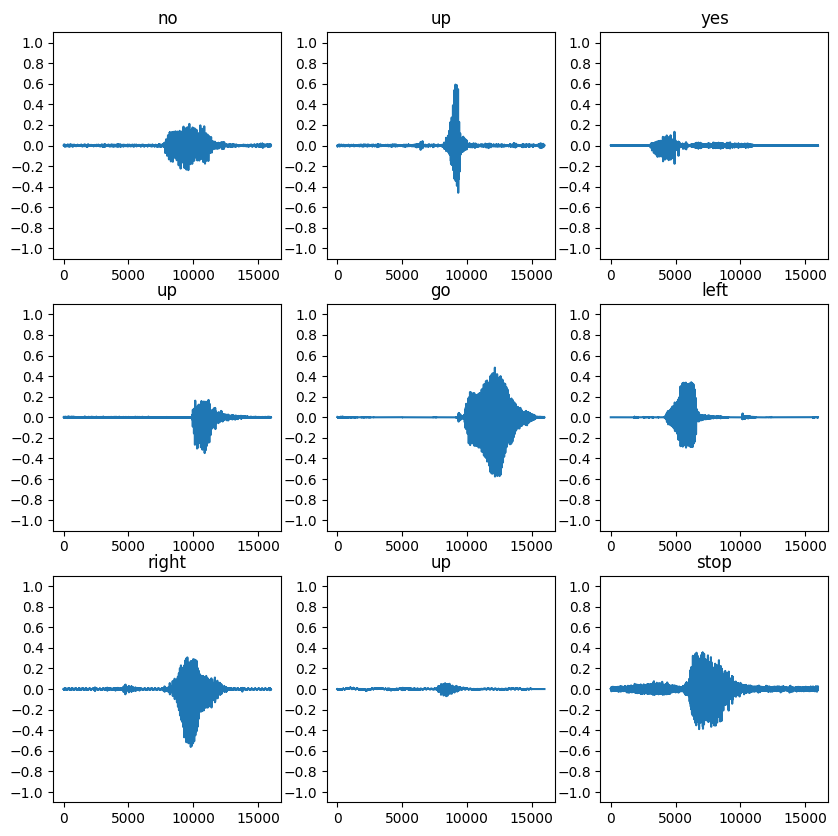

In [67]:
plt.figure(figsize=(10,10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
  plt.subplot(rows, cols, i+1)
  audio_signal = audio[i]
  plt.plot(audio_signal)
  plt.title(label_names[label[i]])
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  plt.ylim([-1.1, 1.1])

In [71]:
label[1]

<tf.Tensor: shape=(), dtype=int32, numpy=6>

In [76]:
def get_spectrogram(waveform):
  waveform = tf.signal.stft(waveform,frame_length=255,frame_step=128)
  spectrogram = tf.abs(waveform)
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

Our Cnn canot work with speechs so we must convert it into image with (height,width,channel) in this we must keep channel becuase cnn work with this.

In [84]:
for i in range(3):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)
  print("Label: ",label)
  print("Wavefrom shape: ",waveform.shape)
  print("Spectrogram shape: ",len(spectrogram.shape))

  display.display(display.Audio(waveform, rate=16000))

Label:  up
Wavefrom shape:  (16000,)
Spectrogram shape:  3


Label:  down
Wavefrom shape:  (16000,)
Spectrogram shape:  3


Label:  no
Wavefrom shape:  (16000,)
Spectrogram shape:  3


In [82]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

The values of the spectrograms varies so must log these values and add epsilon to avoid log of 0

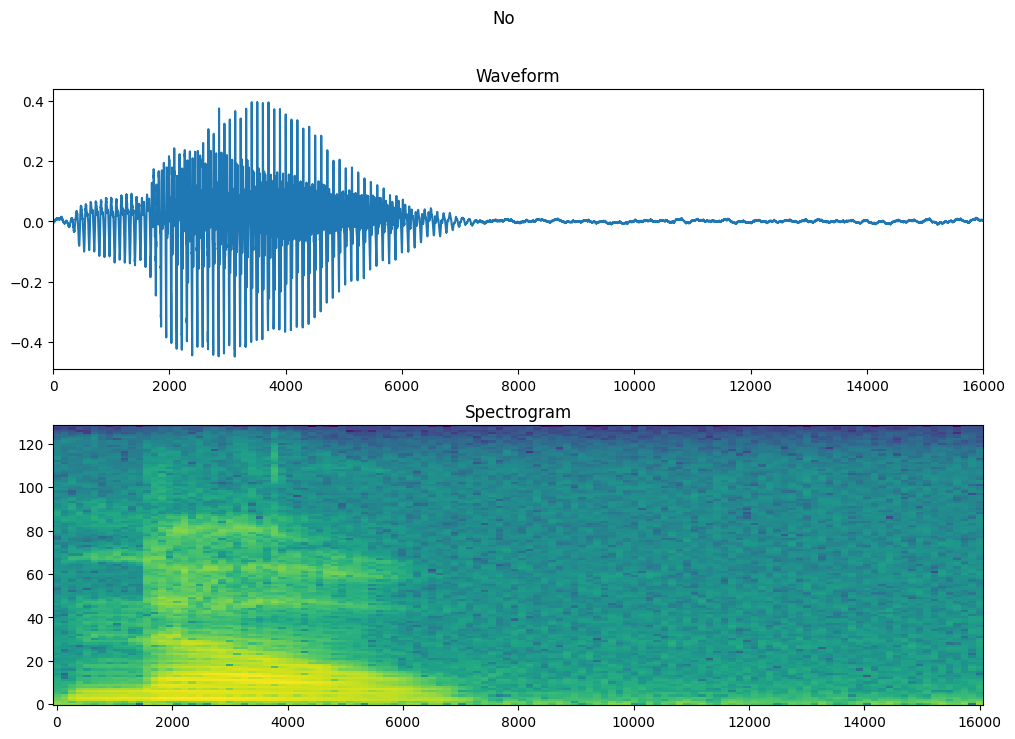

In [86]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

In [98]:
waveform

<tf.Tensor: shape=(16000,), dtype=float32, numpy=
array([-0.00152588, -0.00210571, -0.00094604, ...,  0.00323486,
        0.00305176,  0.0022583 ], dtype=float32)>

In [99]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

Now we again make dataset but this train by using spectrogram

In [100]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

In [101]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

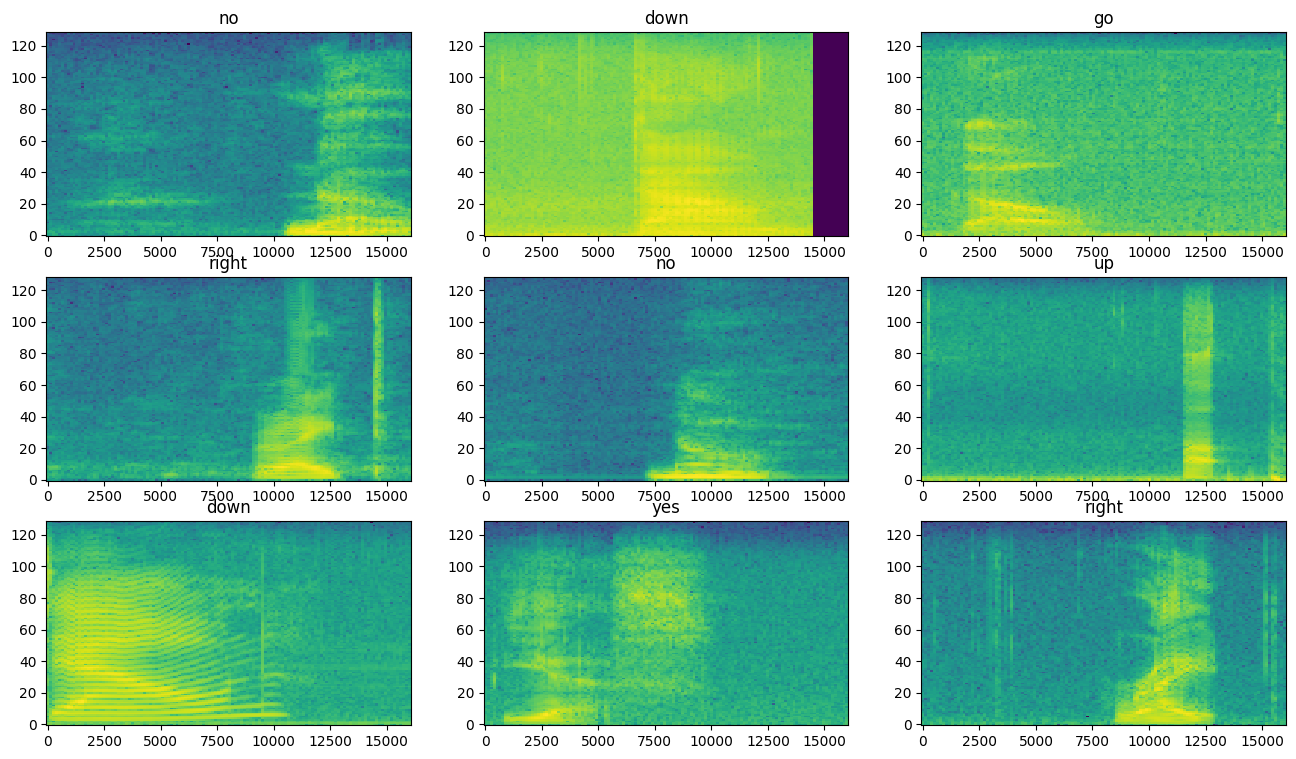

In [102]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()


In [103]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

In [108]:
input_shape = example_spectrograms.shape[1:]
num_labels = len(label_names)

In [109]:
# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])


In [110]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing (Resizing)             │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization (Normalization)   │ (None, 32, 32, 1)      │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,625,611 (6.20 MB)

 Trainable params: 1,625,608 (6.20 MB)

 Non-trainable params: 3 (16.00 B)

In [111]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [112]:
EPOCHS = 10
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 16s 143ms/step - accuracy: 0.2865 - loss: 1.9159 - val_accuracy: 0.5794 - val_loss: 1.3034
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 0.5479 - loss: 1.2698 - val_accuracy: 0.7057 - val_loss: 0.9276
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 136ms/step - accuracy: 0.6618 - loss: 0.9496 - val_accuracy: 0.7513 - val_loss: 0.7930
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 133ms/step - accuracy: 0.7182 - loss: 0.7785 - val_accuracy: 0.7865 - val_loss: 0.6658
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 131ms/step - accuracy: 0.7818 - loss: 0.6241 - val_accuracy: 0.8138 - val_loss: 0.6312
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 131ms/step - accuracy: 0.7949 - loss: 0.5842 - val_accuracy: 0.8294 - val_loss: 0.5585
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 140ms/step - accuracy: 0.8200 - loss: 0.5132 - val_accuracy: 0.8333 - val_loss: 0.5263
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 136ms/step - accuracy: 0.8424 - loss: 0

In [113]:
model.evaluate(test_spectrogram_ds)

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - accuracy: 0.8133 - loss: 0.5415


[0.5214386582374573, 0.8221153616905212]

In [122]:
y_pred = model.predict(test_spectrogram_ds)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


In [123]:
y_pred = tf.argmax(y_pred,axis = 1)

In [125]:
y_true = tf.concat([y for x, y in test_spectrogram_ds], axis = 0)

In [126]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_true,y_pred))

[[81 14  2  5  3  2  0  2]
 [11 67  0 20  2  0  0  0]
 [ 1  1 94  1  6  0  2  3]
 [ 5 13  4 80  3  0  0  0]
 [ 1  0  1  1 82  0  0  0]
 [ 3  3  4  0  4 87  9  1]
 [ 0  4  3  0  1  1 94  0]
 [ 0  0  6  3  3  0  0 99]]


In [ ]:
x = data_dir/'no/01bb6a2a_nohash_0.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

prediction = model(x)
x_labels = ['no', 'yes', 'down', 'go', 'left', 'up', 'right', 'stop']
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title('No')
plt.show()

display.display(display.Audio(waveform, rate=16000))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Text(0.5, 1.0, 'Left')

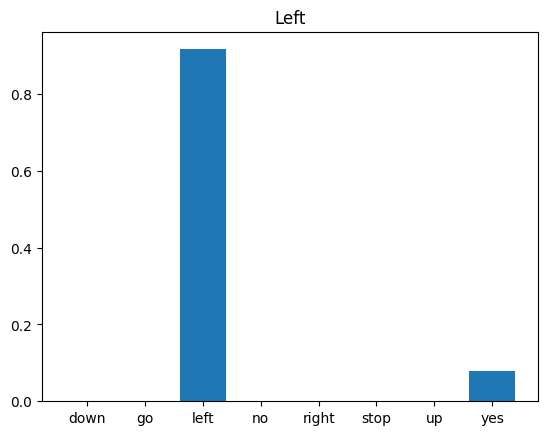

In [131]:
path = '/content/data/mini_speech_commands_extracted/mini_speech_commands/left/012c8314_nohash_0.wav'
x = tf.io.read_file(path)
y,sc = tf.audio.decode_wav(x,desired_channels=1,desired_samples=16000)
y = tf.squeeze(y,axis = -1)
waveform = y
spectrogram = get_spectrogram(waveform)
spectrogram = spectrogram[tf.newaxis,...]
pred = model.predict(spectrogram)
x_labels = ['down','go','left','no','right','stop','up','yes']
plt.bar(x_labels,tf.nn.softmax(pred[0]))
plt.title('Left')

In [130]:
label_names[np.argmax(pred)]

np.str_('left')

In [132]:
display.display(display.Audio(waveform, rate=16000))

That's it if you find this notebook helpful please like it.
